# Introduction to Time Series Forecasting

<a> https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089 <a>

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
# Libraries for Plotting

from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

In [16]:
# Libraries for model selection

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [4]:
# adjust display settings

%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Data Preparation

### Load and Explore Time Series Data

In [22]:
# load dataset

dataframe = pd.read_csv('FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [30]:
# display first few lines of a time series

dataframe.head()

,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.06
1954-10-01,0.85
1954-11-01,0.83


In [33]:
# the index is in datetime format, which is fine

dataframe.index[:5]

DatetimeIndex(['1954-07-01', '1954-08-01', '1954-09-01', '1954-10-01',
               '1954-11-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [35]:
# however, this doesn't look good yet

dataframe.head().values

array([[0.8 ],
       [1.22],
       [1.06],
       [0.85],
       [0.83]], dtype=float32)

In [37]:
# unstacking the data might help...

dataframe.unstack().head()

          DATE      
FEDFUNDS  1954-07-01   0.80
          1954-08-01   1.22
          1954-09-01   1.06
          1954-10-01   0.85
          1954-11-01   0.83
dtype: float32

In [39]:
# and it does

dataframe.unstack().head().values

array([0.8 , 1.22, 1.06, 0.85, 0.83], dtype=float32)

#### Create Time Series

Pandas represents time series datasets as a Series. A Series is a one-dimensional array with a time label for each row.

In [41]:
# create a time series

s = pd.Series(dataframe.unstack().values, index=dataframe.index)

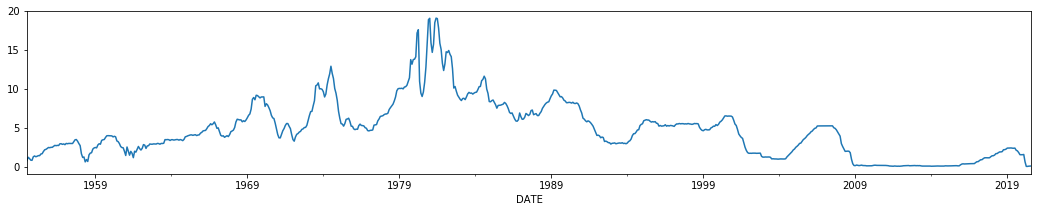

In [44]:
# basic plot
s.plot()

In [46]:
# query a dataset using a date-time index

# This and the following step is for Train-test split (80:20 proportion)
# This is for Train sample

# In "our" case since we have a short data, that's why we will not split it into train and test datasets:

s[:'2007'].tail(10)

DATE
2007-03-01   5.26
2007-04-01   5.25
2007-05-01   5.25
2007-06-01   5.25
2007-07-01   5.26
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
dtype: float32

In [50]:
# keep only data before 2008 
s = s[:'2007']

#### Explore Time Series Data

In [51]:
# display first few lines of a time series
s.head()

DATE
1954-07-01   0.80
1954-08-01   1.22
1954-09-01   1.06
1954-10-01   0.85
1954-11-01   0.83
dtype: float32

In [52]:
s.index[:5]

DatetimeIndex(['1954-07-01', '1954-08-01', '1954-09-01', '1954-10-01',
               '1954-11-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [53]:
# display last few lines of a time series
s.tail()

DATE
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
dtype: float32

In [54]:
# summarize the dimensions of a time series

s.size

642

In [56]:
# calculate descriptive statistics

s.describe()

count   642.00
mean      5.69
std       3.32
min       0.63
25%       3.29
50%       5.25
75%       7.30
max      19.10
dtype: float64

#### Basic Feature Engineering

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms. There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

A time series dataset must be transformed to be modeled as a supervised learning problem. We need to transform something that looks like:

* time 1, value 1
* time 2, value 2
* time 3, value 3

into something that looks like:

* input 1, output 1
* input 2, output 2
* input 3, output 3

##### Date Time Features

In [162]:
# The simplest features that we can use are features from the date/time of each observation.

df = pd.DataFrame()
df['year'] = [s.index[i].year for i in range(len(s))]
df['month'] = [s.index[i].month for i in range(len(s))]
df['value'] = s.values.tolist()

In [142]:
df.head()

,year,month,value
0,1954,7,0.80
1,1954,8,1.22
2,1954,9,1.06
3,1954,10,0.85
4,1954,11,0.83


#### Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted values looks as follows:

* Value(t), Value(t+1)
* Value(t), Value(t+1)
* Value(t), Value(t+1)

In [64]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [65]:
df.head()

,t,t+1
0,nan,0.80
1,0.80,1.22
2,1.22,1.06
3,1.06,0.85
4,0.85,0.83


In [66]:
df.tail()

,t,t+1
637,5.26,5.02
638,5.02,4.94
639,4.94,4.76
640,4.76,4.49
641,4.49,4.24


#### WIndow Features

The addition of lag features is called the sliding window method, in this case with a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width. We can expand the window width and include more lagged features.

In [70]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df.columns = ['t-2', 't-1', 't', 't+1']

In [71]:
df.head()

,t-2,t-1,t,t+1
0,nan,nan,nan,0.80
1,nan,nan,0.80,1.22
2,nan,0.80,1.22,1.06
3,0.80,1.22,1.06,0.85
4,1.22,1.06,0.85,0.83


In [72]:
df.tail()

,t-2,t-1,t,t+1
637,5.25,5.25,5.26,5.02
638,5.25,5.26,5.02,4.94
639,5.26,5.02,4.94,4.76
640,5.02,4.94,4.76,4.49
641,4.94,4.76,4.49,4.24


#### Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous values, also called the rolling mean.

In [76]:
values = pd.DataFrame(s.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df = pd.concat([means, values], axis=1)
df.columns = ['mean(t-1,t)', 't+1']

In [78]:
df.head()

,"mean(t-1,t)",t+1
0,nan,0.80
1,nan,1.22
2,1.01,1.06
3,1.14,0.85
4,0.95,0.83


In [79]:
df.tail()

,"mean(t-1,t)",t+1
637,5.26,5.02
638,5.14,4.94
639,4.98,4.76
640,4.85,4.49
641,4.62,4.24


In [84]:
# Another one:

values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [85]:
df.head()

,min,mean,max,t+1
0,nan,nan,nan,0.80
1,nan,nan,nan,1.22
2,nan,nan,nan,1.06
3,nan,nan,nan,0.85
4,0.80,1.03,1.22,0.83


In [86]:
df.head()

,min,mean,max,t+1
0,nan,nan,nan,0.80
1,nan,nan,nan,1.22
2,nan,nan,nan,1.06
3,nan,nan,nan,0.85
4,0.80,1.03,1.22,0.83


#### Expanding Window Statistics

Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data.

In [90]:
values = pd.DataFrame(s.values)
window = values.expanding()

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [91]:
df.head()

,min,mean,max,t+1
0,0.80,0.80,0.80,0.80
1,0.80,1.01,1.22,1.22
2,0.80,1.03,1.22,1.06
3,0.80,0.98,1.22,0.85
4,0.80,0.95,1.22,0.83


In [92]:
df.tail()

,min,mean,max,t+1
637,0.63,5.70,19.10,5.02
638,0.63,5.70,19.10,4.94
639,0.63,5.69,19.10,4.76
640,0.63,5.69,19.10,4.49
641,0.63,5.69,19.10,4.24


#### Data Visualization

Time series lends itself naturally to visualization. Line plots of observations over time are popular, but there is a suite of other plots that you can use to learn more about your problem. The more you learn about your data, the more likely you are to develop a better forecasting model.

##### Line Plot

Perhaps the most popular visualization for time series is the line plot. In this plot, time is shown on the x-axis with observation values along the y-axis

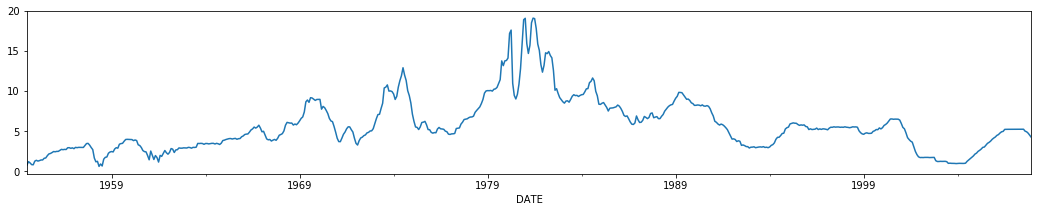

In [96]:
s.plot()

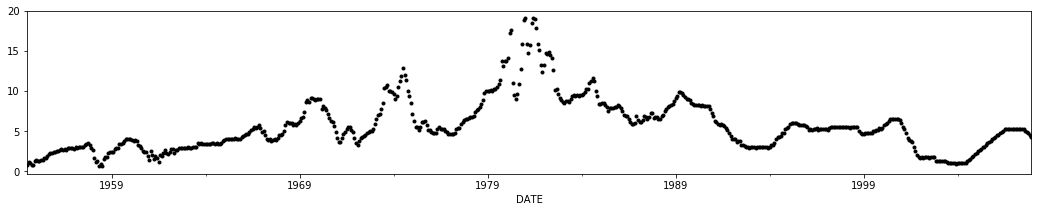

In [100]:
s.plot(style='k.');

#### Histogram and Density Plots

Another important visualization is of the distribution of observations themselves. This means a plot of the values without the temporal ordering. Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed.

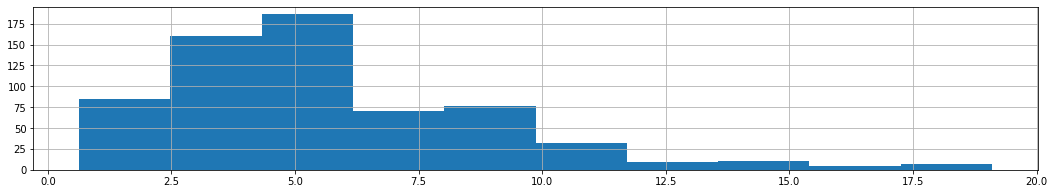

In [103]:
s.hist();

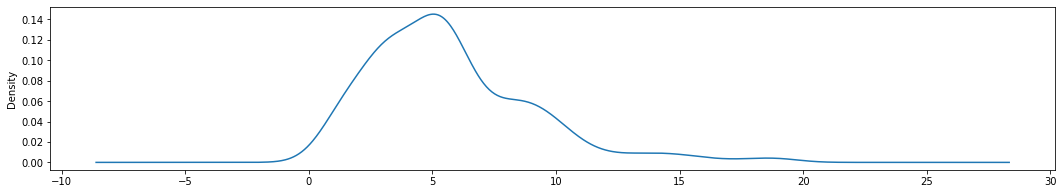

In [107]:
s.plot(kind='kde');

#### Lag Scatter Plots

Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag=1, the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.

* If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
* If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
* Either relationship is good as they can be modeled.

More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship. A ball in the middle or a spread across the plot suggests a weak or no relationship.

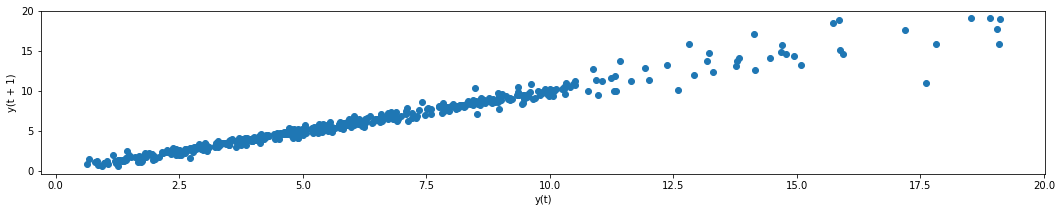

In [180]:
# create a scatter plot

lag_plot(s);

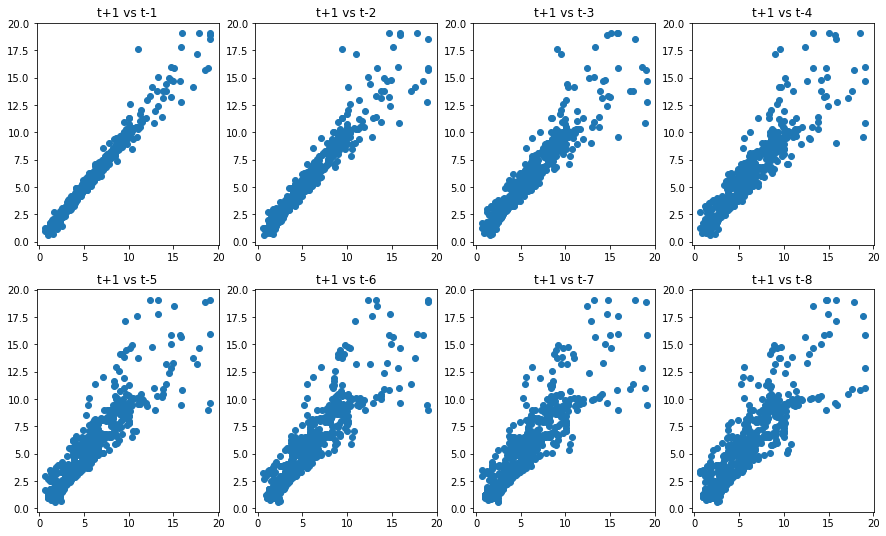

In [183]:
# create multiple scatter plots

values = pd.DataFrame(s.values)
lags = 8
columns = [values]

for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

df = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
df.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)

#### Autocorrelation Plots

We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). A correlation value calculated between two groups of numbers, such as observations and their lag=1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.

Correlation values, called correlation coeficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot.

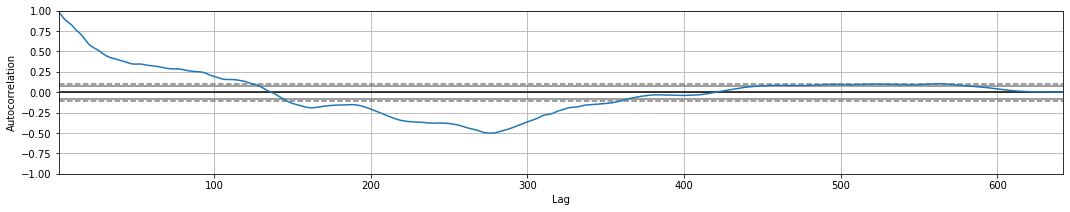

In [188]:
# create an autocorrelation plot

autocorrelation_plot(s);

The Statsmodels library also provides a version of the autocorrelation plot as a line plot. Plots lags on the horizontal and the correlations on vertical axis.

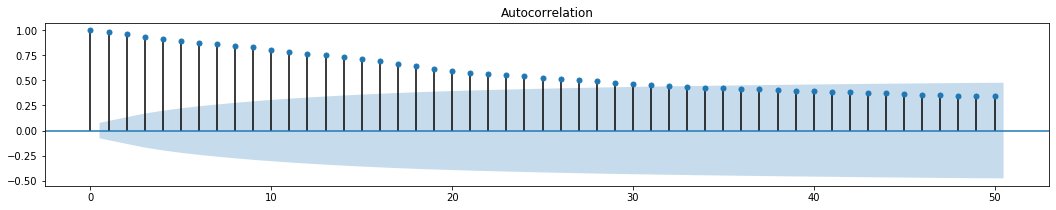

In [191]:
# autocorrelation plot of time series as a line plot

plot_acf(s, lags=50)
plt.show();

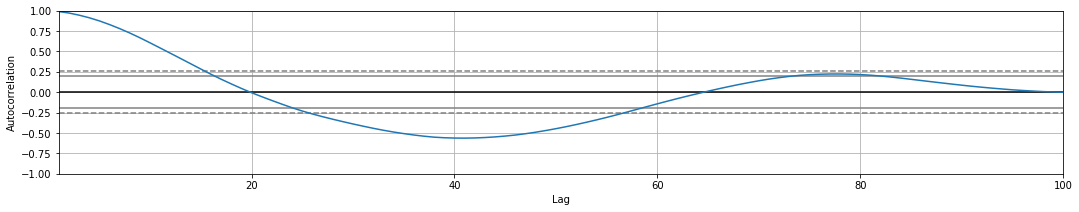

In [195]:
# create an autocorrelation plot, using only the last 100 entries

autocorrelation_plot(s[-100:]);

In [1]:
# For our case
# create an autocorrelation plot, using only the last 8 entries

autocorrelation_plot(ourS[-8:]);

NameError: name 'autocorrelation_plot' is not defined

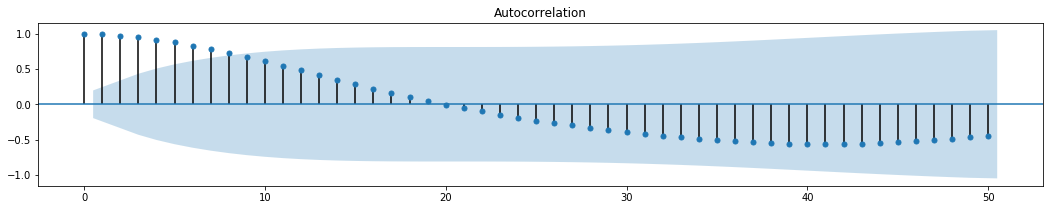

In [197]:
# autocorrelation plot of time series as a line plot

plot_acf(s[-100:], lags=50)
plt.show()